https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#7.-Usage-with-sklearn-GridSearchCV

In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install pandas_ta
!pip install yfinance
!pip install scikeras
!pip install keras-tuner --upgrade

In [2]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
sys.path.append('/content/gdrive/MyDrive/mgr_files')

2023-05-20 20:50:21.963673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 20:50:22.775060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-20 20:50:22.775092: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-20 20:50:25.129841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


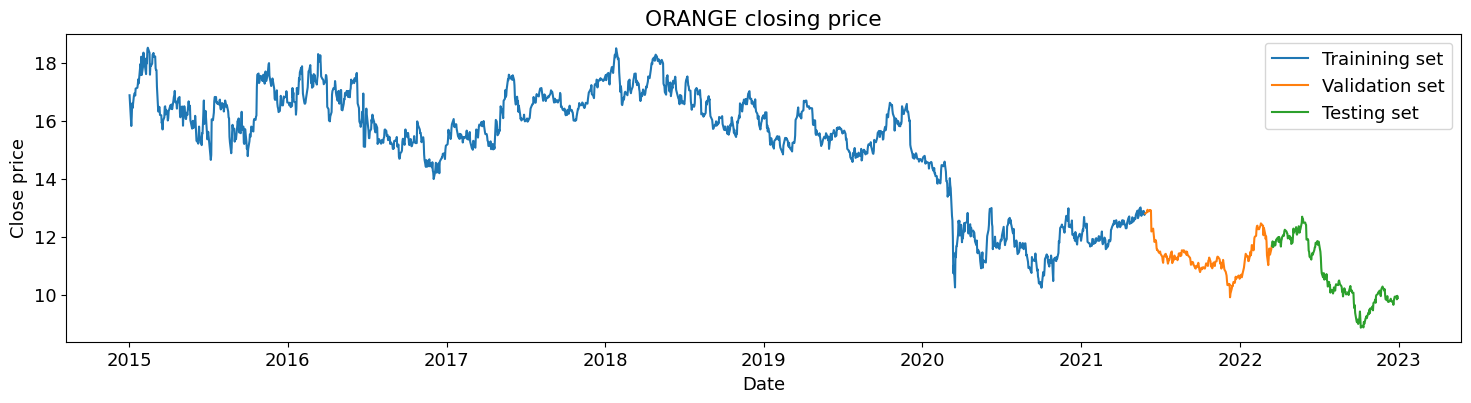

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


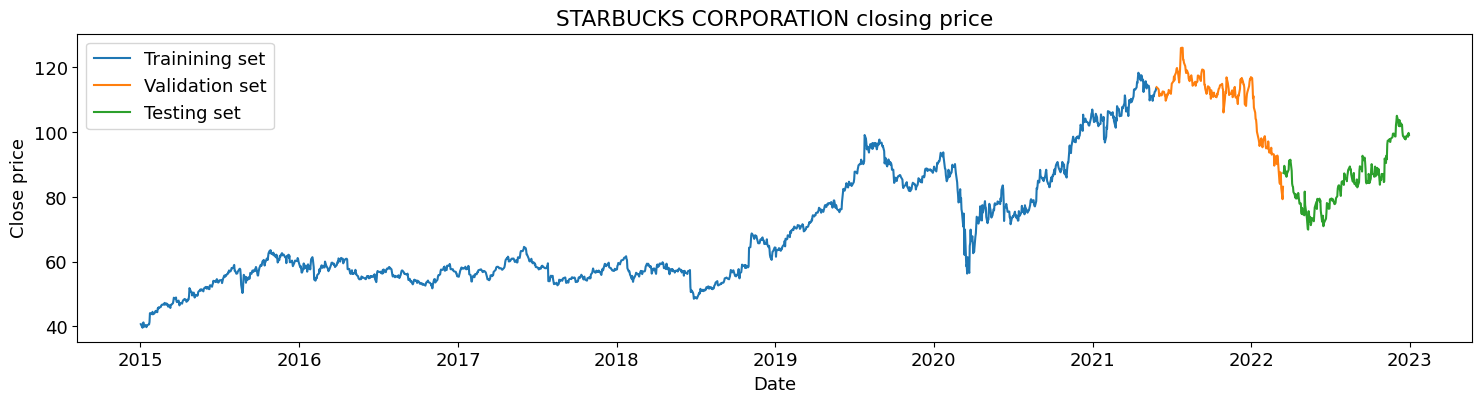

[*********************100%***********************]  1 of 1 completed
2060
1648
206
206


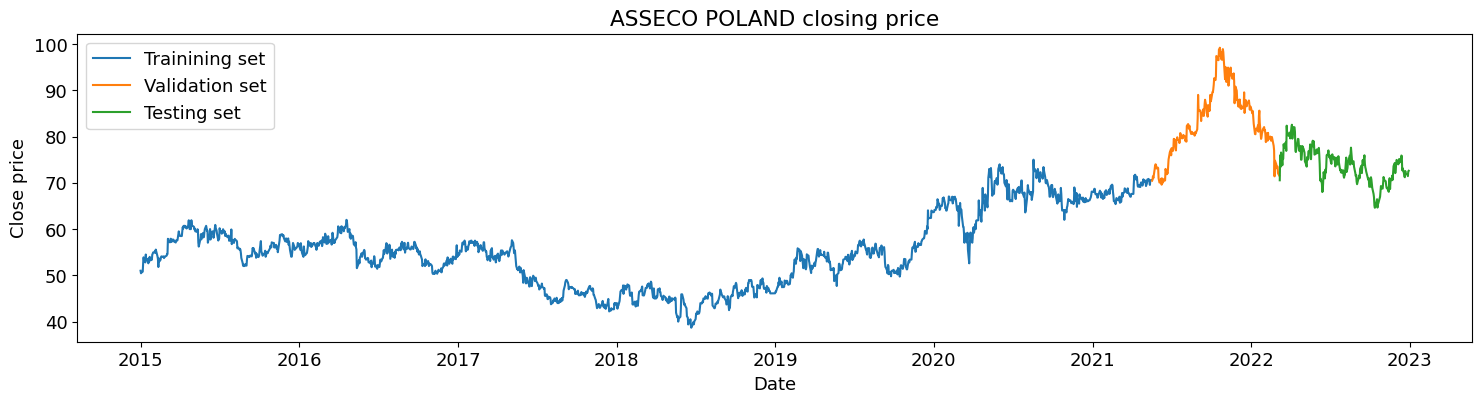

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


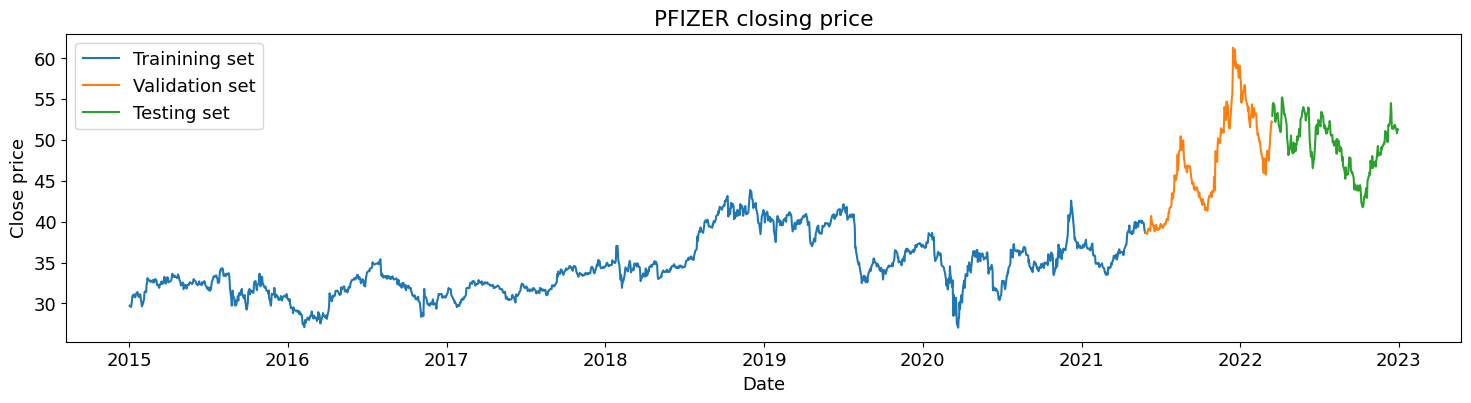

In [2]:
from my_library import *

In [3]:
data3['Volume'] = data3['Volume'].replace(to_replace=0,value=np.nan).ffill()
data3.dropna(inplace=True)

# LSTM

## Stock 1

In [ ]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 2
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 2
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=100,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 100 Complete [00h 00m 41s]
val_loss: 0.5955395698547363

Best val_loss So Far: 0.581046998500824
Total elapsed time: 00h 54m 45s


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

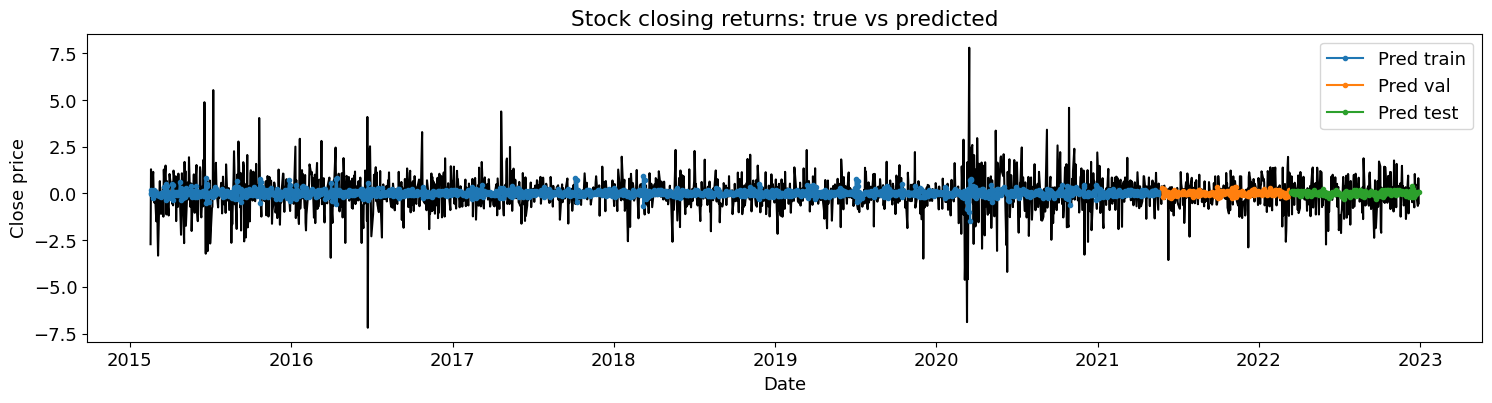

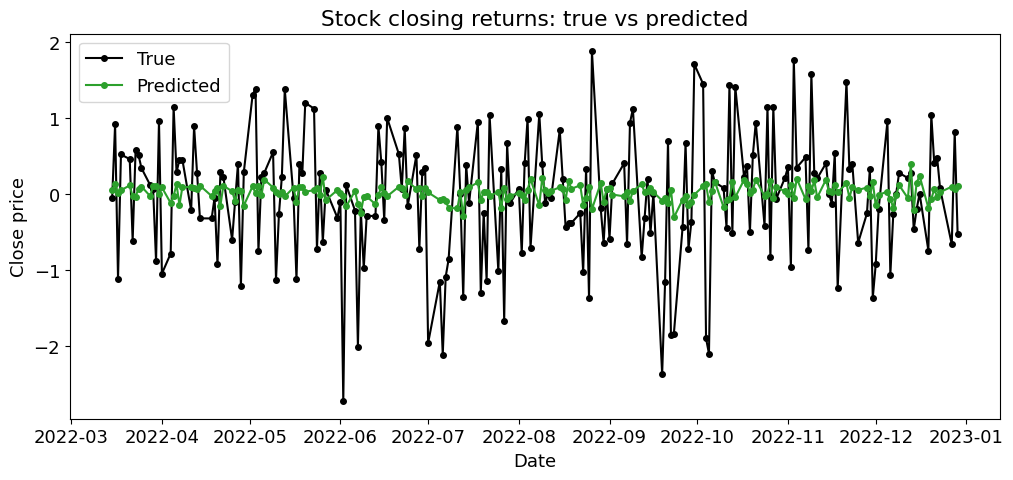

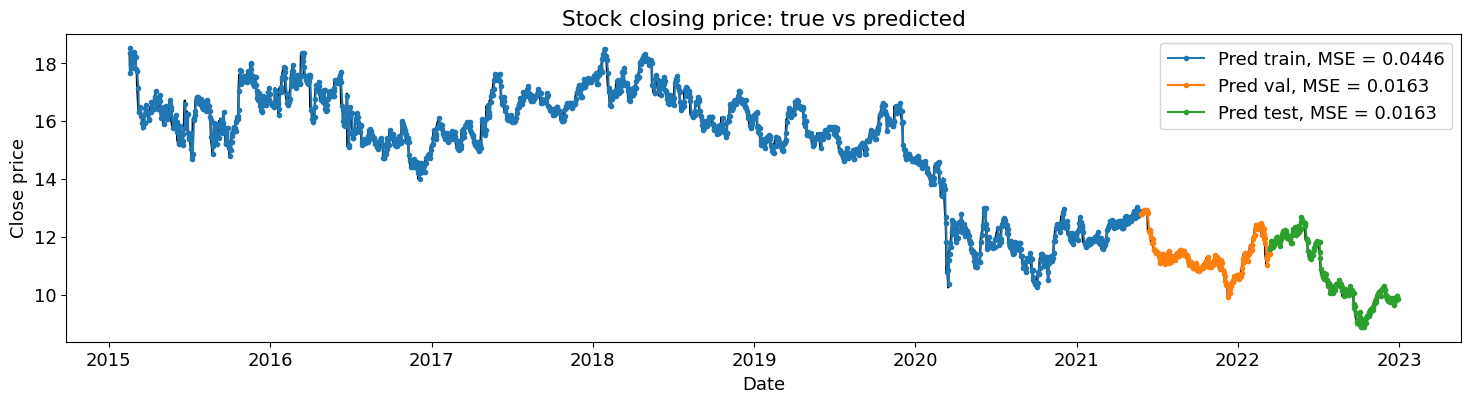

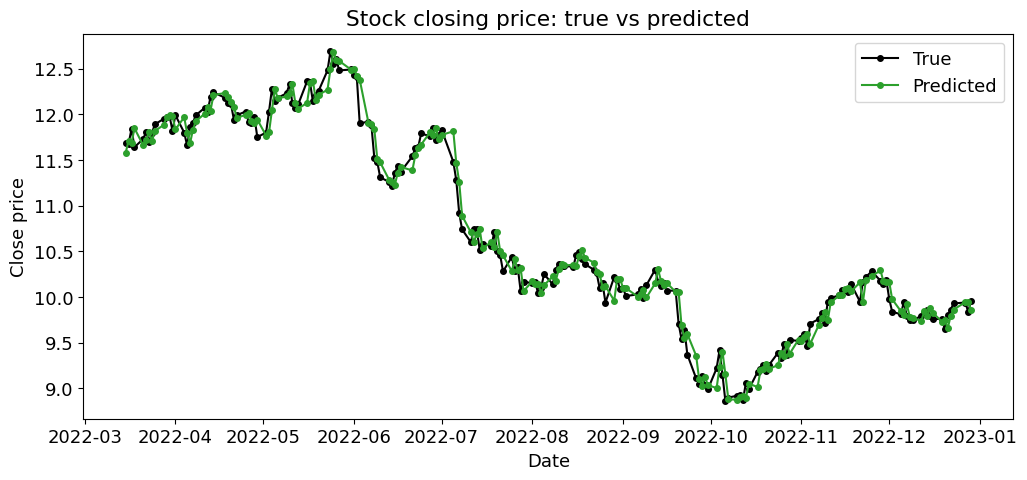

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 047 summary
Hyperparameters:
num_layers: 1
units_0: 256
dropout_0: 0.2
units_dense: 256
activation_dense: tanh
units_1: 128
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
Score: 0.581046998500824

Trial 045 summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.2
units_dense: 64
activation_dense: tanh
units_1: 8
dropout_1: 0.2
units_2: 512
dropout_2: 0.2
Score: 0.5843439996242523

Trial 044 summary
Hyperparameters:
num_layers: 2
units_0: 256
dropout_0: 0.2
units_dense: 64
activation_dense: relu
units_1: 256
dropout_1: 0.2
units_2: 16
dropout_2: 0.2
Score: 0.5850333869457245
None


In [ ]:
best_model_check(data, tuner, best_model, window_size=30, features=2)
print(tuner.results_summary(num_trials=3))

## Stock 2

In [ ]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 2
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 2
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=100,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data2, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 100 Complete [00h 00m 25s]
val_loss: 0.8888423144817352

Best val_loss So Far: 0.8888423144817352
Total elapsed time: 00h 47m 17s


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

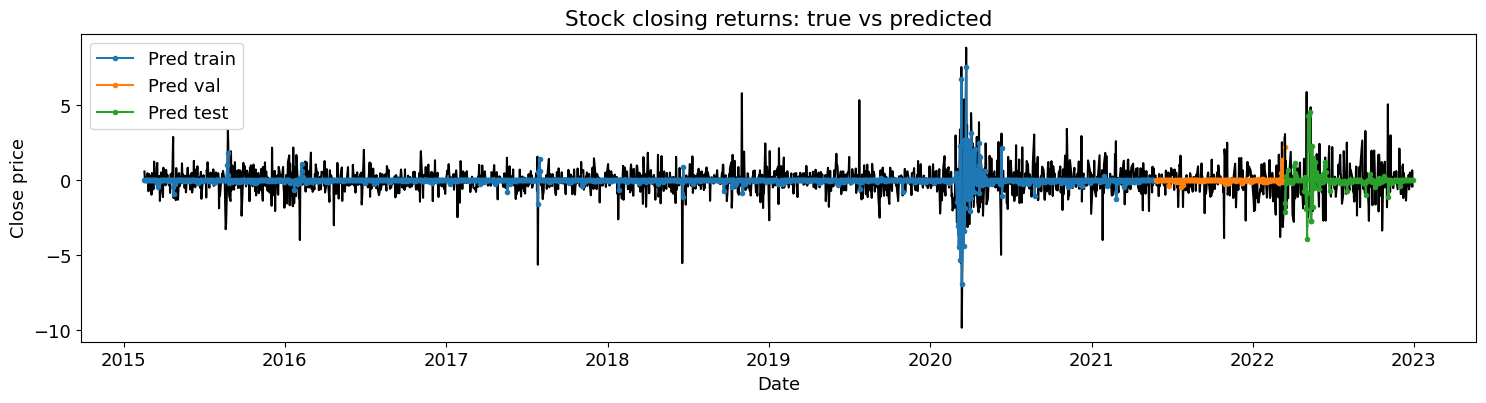

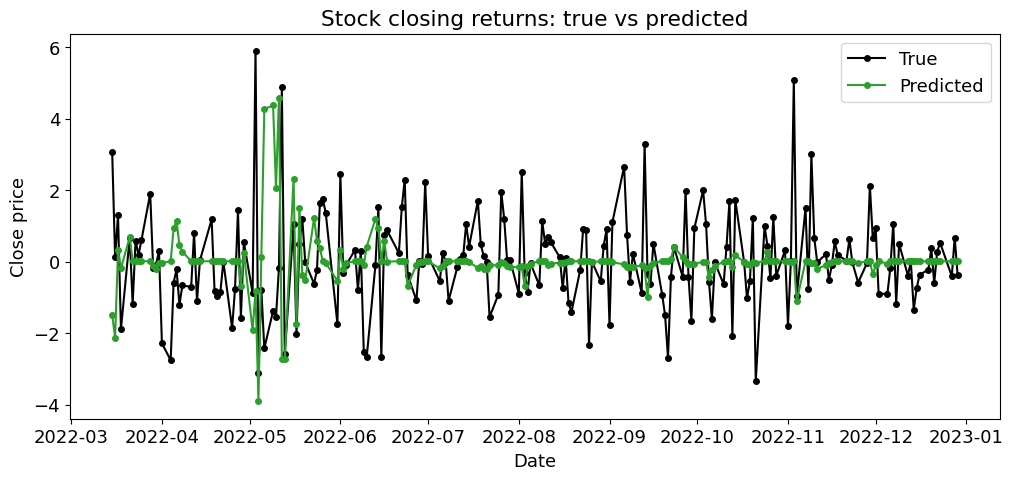

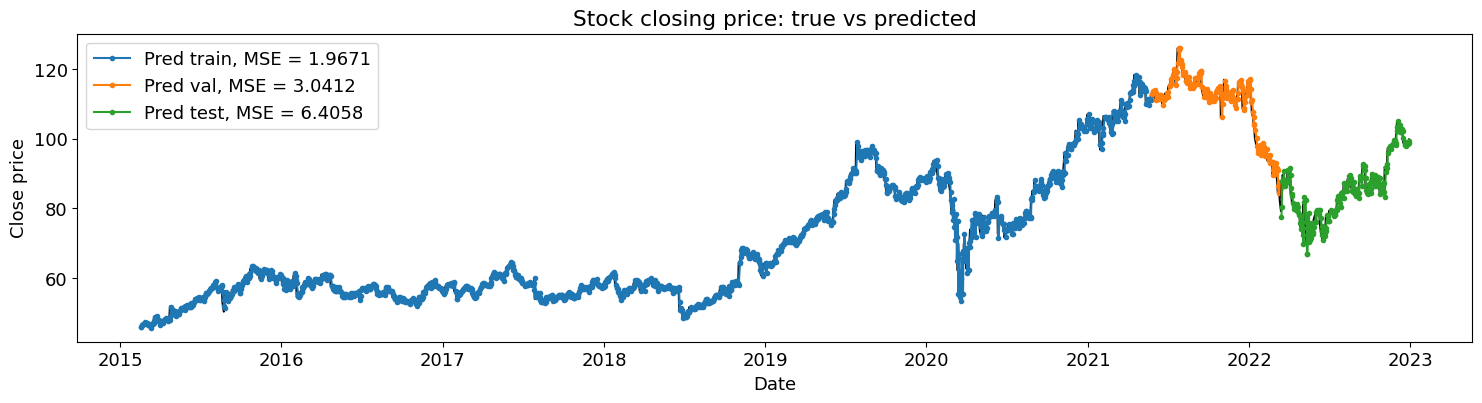

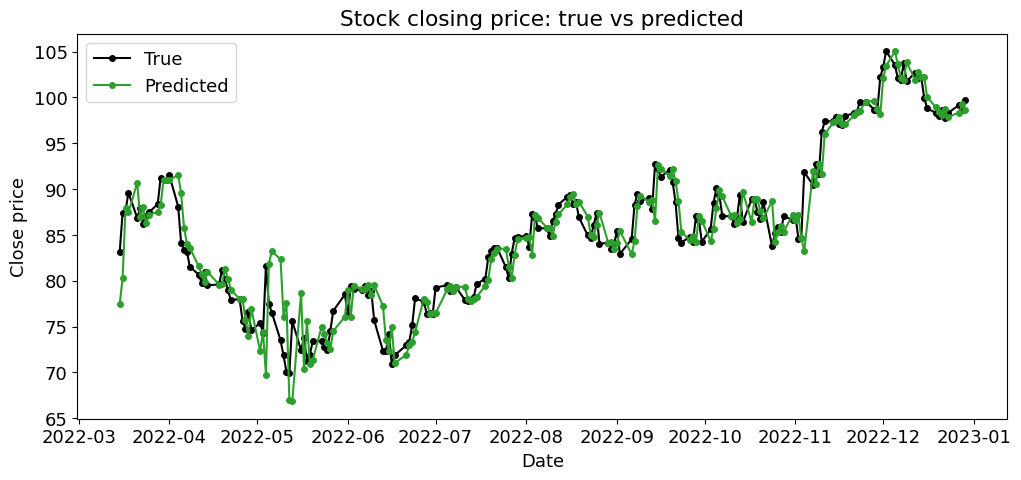

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 099 summary
Hyperparameters:
num_layers: 1
units_0: 16
dropout_0: 0.2
units_dense: 8
activation_dense: relu
units_1: 16
dropout_1: 0.2
units_2: 32
dropout_2: 0.0
Score: 0.8888423144817352

Trial 087 summary
Hyperparameters:
num_layers: 1
units_0: 32
dropout_0: 0.2
units_dense: 16
activation_dense: relu
units_1: 16
dropout_1: 0.0
units_2: 32
dropout_2: 0.2
Score: 0.8907287120819092

Trial 072 summary
Hyperparameters:
num_layers: 1
units_0: 16
dropout_0: 0.2
units_dense: 8
activation_dense: relu
units_1: 32
dropout_1: 0.0
units_2: 64
dropout_2: 0.2
Score: 0.8923398554325104
None


In [ ]:
best_model_check(data2, tuner, best_model, window_size=30, features=2)
print(tuner.results_summary(num_trials=3))

## Stock 3

In [4]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 2
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 2
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data3, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 00m 42s]
val_loss: 1.098819613456726

Best val_loss So Far: 1.0881057381629944
Total elapsed time: 02h 31m 07s
INFO:tensorflow:Oracle triggered exit


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

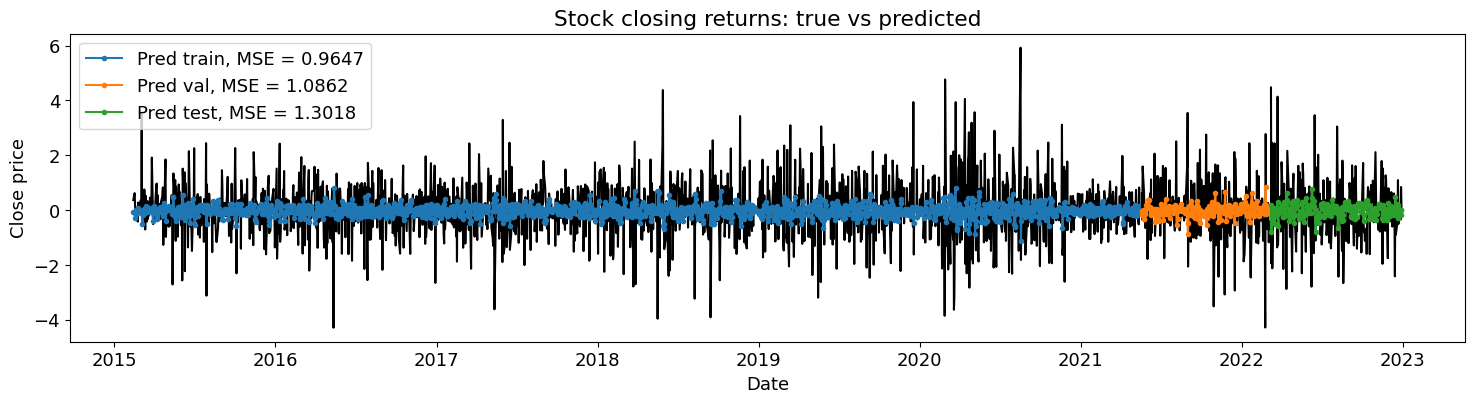

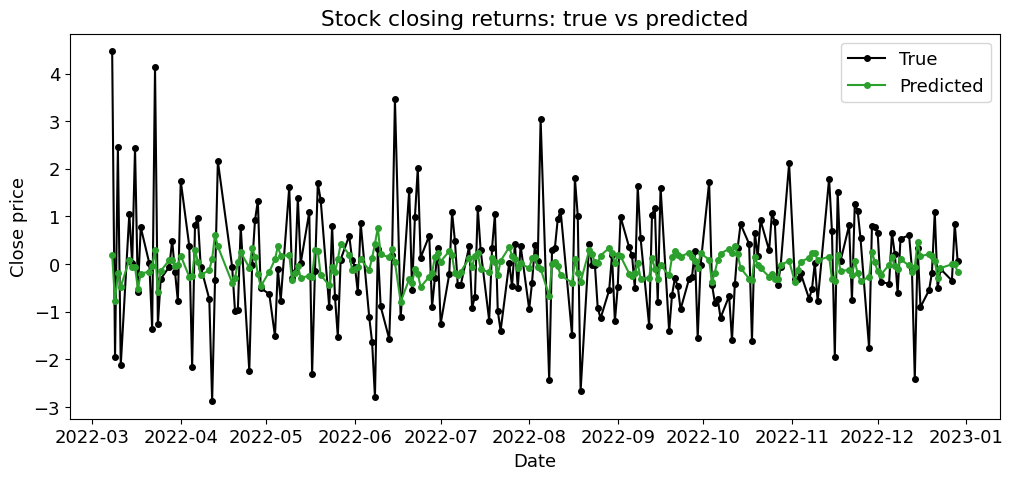

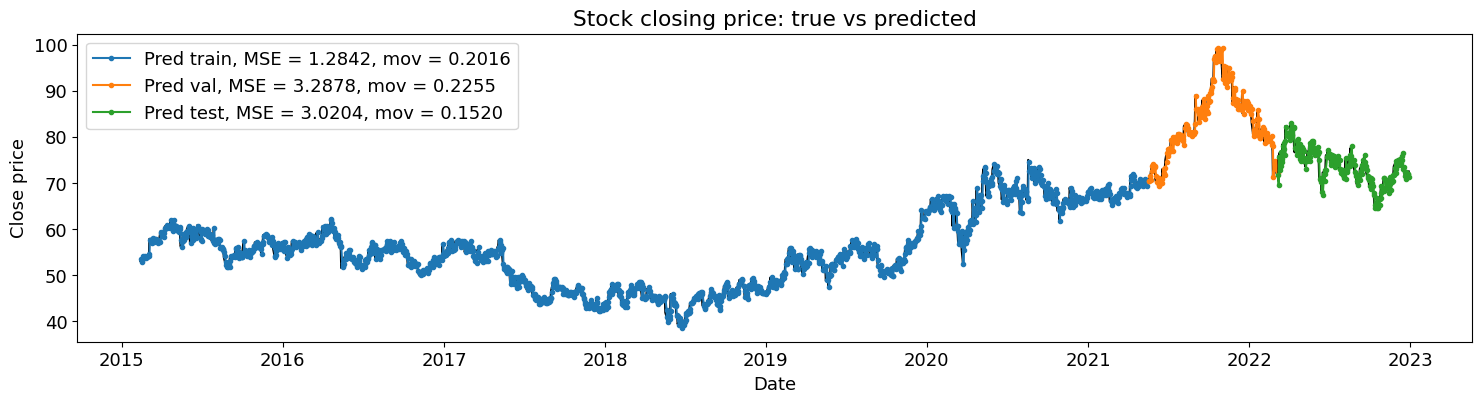

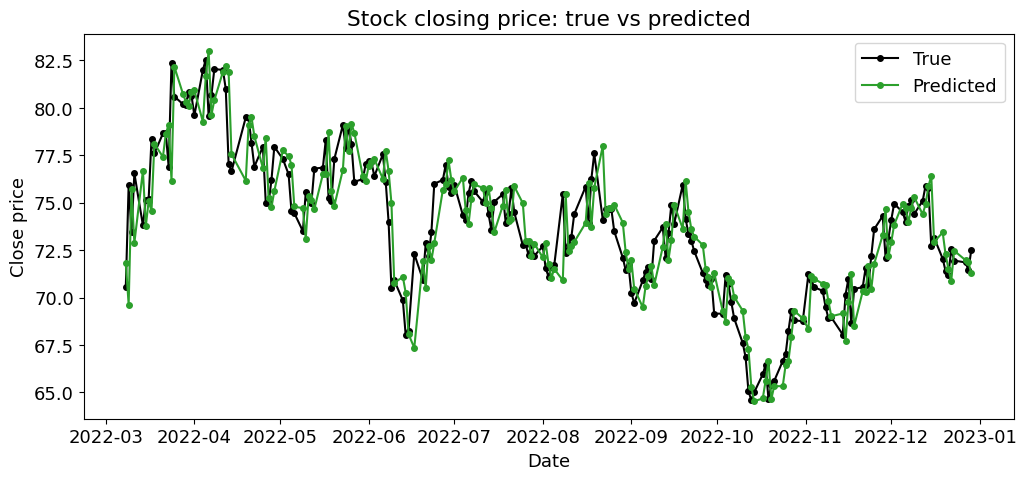

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 2
units_0: 64
dropout_0: 0.2
units_dense: 128
activation_dense: tanh
units_1: 64
dropout_1: 0.0
units_2: 256
dropout_2: 0.0
Score: 1.0881057381629944
None


In [5]:
best_model_check(data3, tuner, best_model, window_size=30, features=2)
print(tuner.results_summary(num_trials=1))

## Stock 4

In [6]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 2
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 2
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data4, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 00m 32s]
val_loss: 2.0309978723526

Best val_loss So Far: 2.003744959831238
Total elapsed time: 05h 21m 44s
INFO:tensorflow:Oracle triggered exit


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

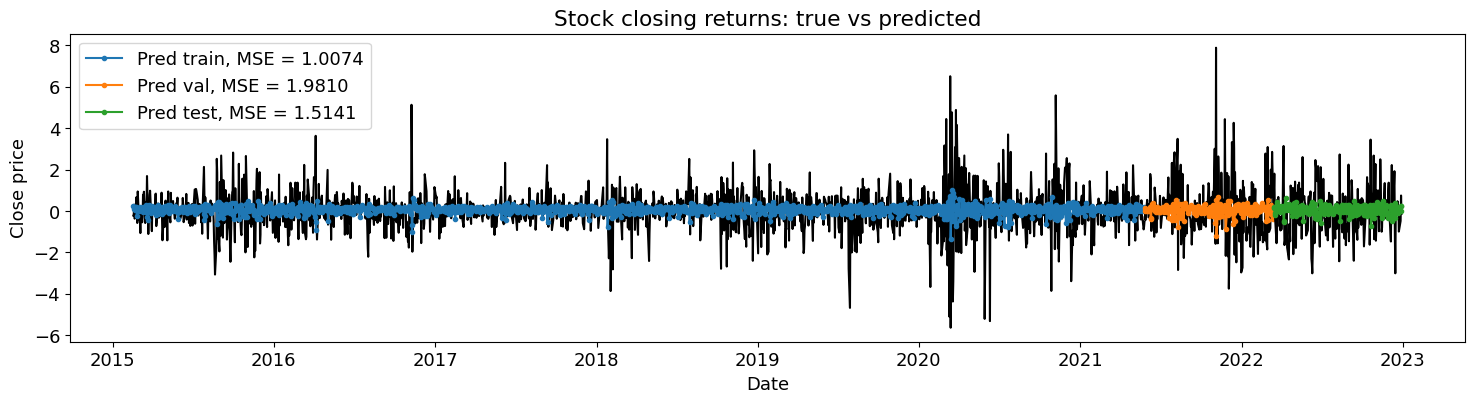

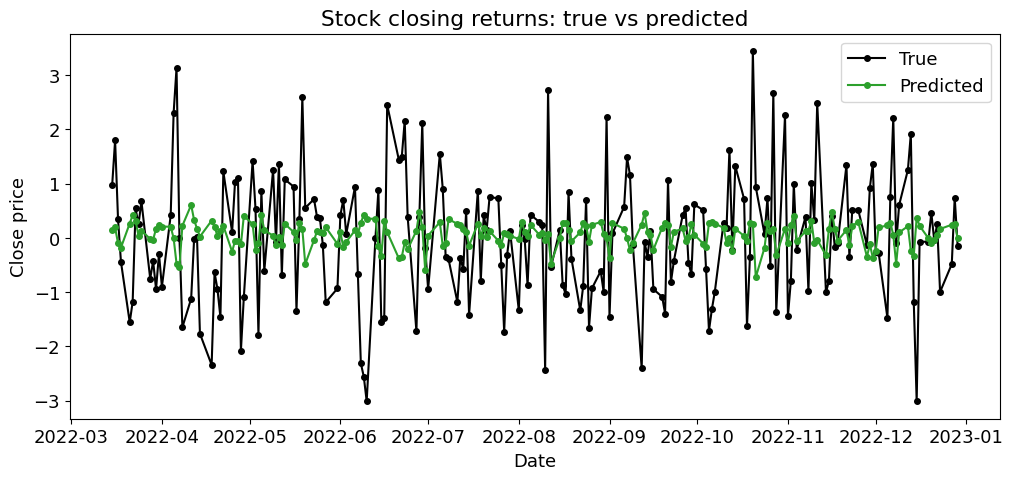

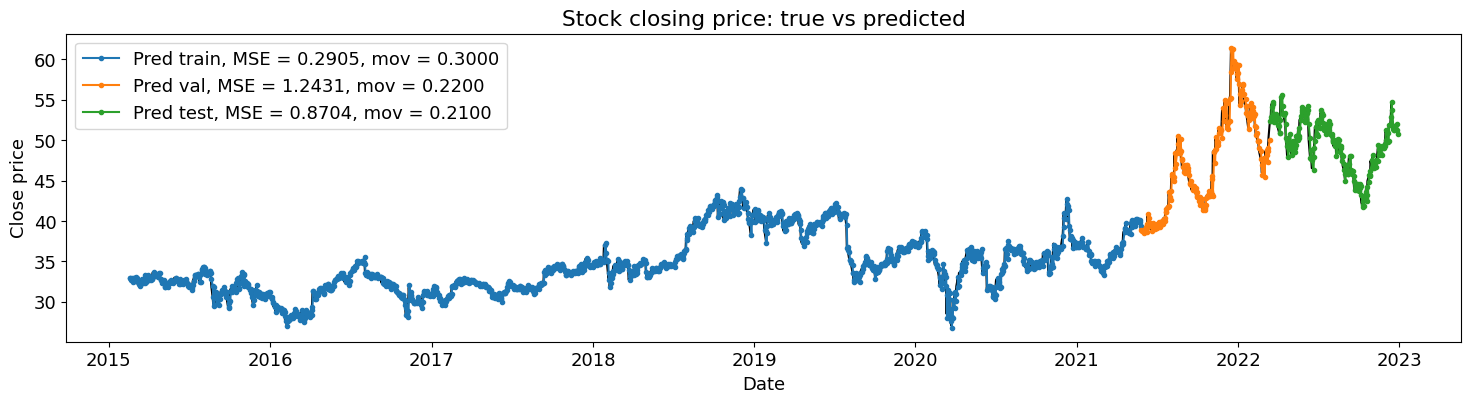

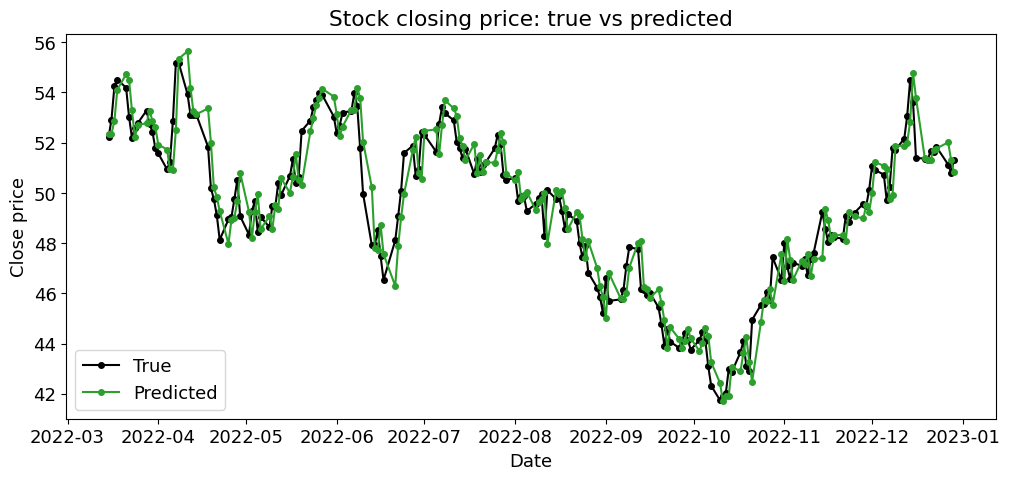

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 14 summary
Hyperparameters:
num_layers: 1
units_0: 256
dropout_0: 0.2
units_dense: 512
activation_dense: tanh
units_1: 64
dropout_1: 0.2
units_2: 32
dropout_2: 0.0
Score: 2.003744959831238

Trial 45 summary
Hyperparameters:
num_layers: 1
units_0: 16
dropout_0: 0.0
units_dense: 128
activation_dense: tanh
units_1: 64
dropout_1: 0.2
units_2: 512
dropout_2: 0.0
Score: 2.0174914598464966

Trial 16 summary
Hyperparameters:
num_layers: 3
units_0: 256
dropout_0: 0.0
units_dense: 256
activation_dense: tanh
units_1: 128
dropout_1: 0.2
units_2: 256
dropout_2: 0.2
Score: 2.020761728286743
None


In [7]:
best_model_check(data4, tuner, best_model, window_size=30, features=2)
print(tuner.results_summary(num_trials=3))